Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train path: /content/drive/MyDrive/datasets/Train_set.csv
Test  path: /content/drive/MyDrive/datasets/Test_set.csv
Train shape: (367767, 54)
Test  shape: (94946, 54)
Columns sample: ['household_ID', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)', 'w1_hh_member_count', 'w1_hh_avg_age', 'w1_hh_num_children', 'w1_hh_num_seniors', 'w1_hh_avg_hours_home', 'w1_hh_share_went_out_for_work', 'w1_num_fans', 'w1_fan_hours_day', 'w1_fan_hours_night', 'w1_num_lights', 'w1_light_total_wattage']
Drop columns: ['household_ID', 'DATE', 'TIME', 'timestamp', 'TOTAL_IMPORT (kWh)']

Number of feature columns: 48

Initial numeric cols: 31
Initial categorical cols: 17

Final numeric feature columns (31):
['w1_hh_member_count', 'w1_hh_avg_age', 'w1_hh_num_children', 'w1_hh_num_seniors', 'w1_hh_avg_hours_home', 'w1_hh_share_went_out_for_work', 'w1_num_fans', 'w1_fan_hours_day', 'w1_fan_hours_n

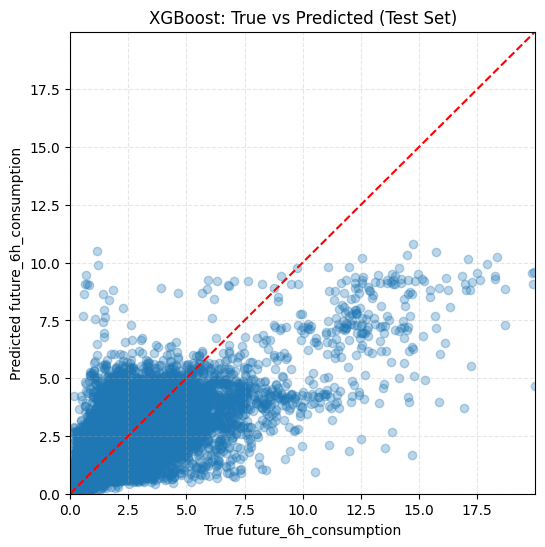


Saved per-sample errors to: /content/drive/MyDrive/datasets/xgboost_test_errors.csv

Top 20 important features (XGBoost):
                                              feature  importance
18                                  w1_total_room_acs    0.284017
13                                       w1_num_rooms    0.067950
51  is_there_business_carried_out_in_the_household...    0.059025
25                           backward_avg_consumption    0.042189
28                               avg_5d_same_time_kwh    0.036115
73                         socio_economic_class_SEC B    0.030119
63     no_of_times_food_cooked_last_week_8 - 14 times    0.021325
34                  built_year_of_the_house_1980-1989    0.021189
22                                               hour    0.020457
38                built_year_of_the_house_Before 1980    0.019061
91  water_heating_method_for_bathing_We have an in...    0.019058
50  is_there_business_carried_out_in_the_household_No    0.016985
29                 

/tmp/ipython-input-2157062600.py:258: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


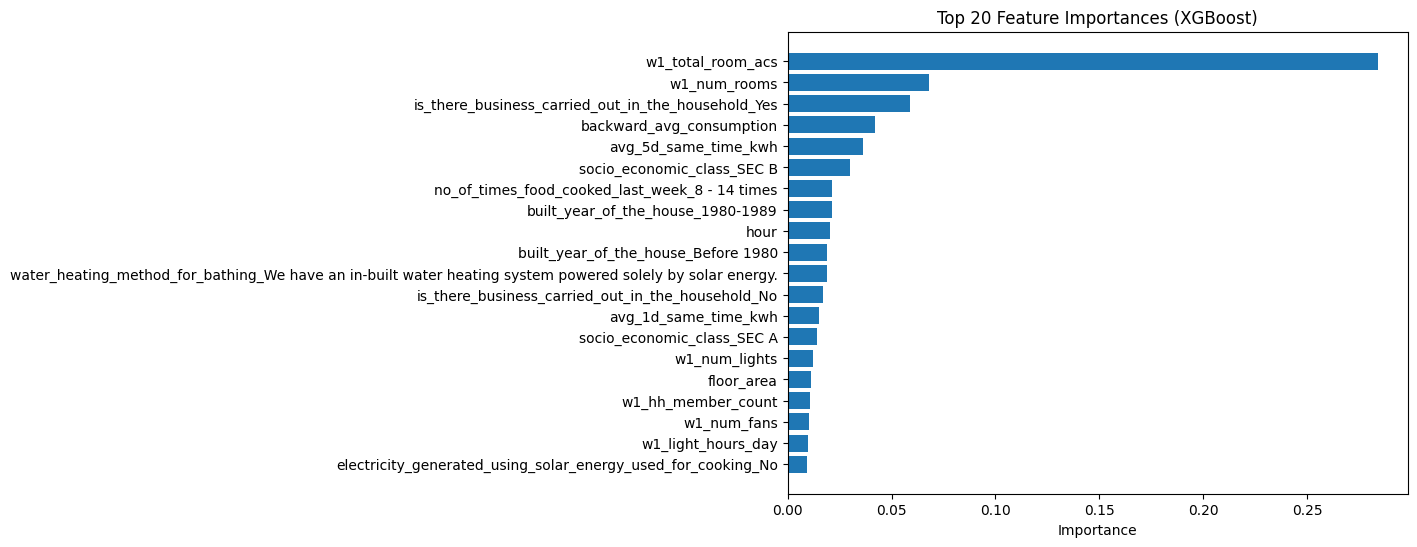

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

%matplotlib inline


TRAIN_PATH = Path("/content/drive/MyDrive/datasets/Train_set.csv")
TEST_PATH  = Path("/content/drive/MyDrive/datasets/Test_set.csv")

print("Train path:", TRAIN_PATH)
print("Test  path:", TEST_PATH)

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print("Columns sample:", train_df.columns[:15].tolist())


target_col = "future_6h_consumption"
if target_col not in train_df.columns:
    raise KeyError(f"Target column '{target_col}' not found in train_df")

drop_cols = [
    "household_ID",
    "DATE",
    "TIME",
    "timestamp",
]


USE_TOTAL_IMPORT_AS_FEATURE = False
if not USE_TOTAL_IMPORT_AS_FEATURE and "TOTAL_IMPORT (kWh)" in train_df.columns:
    drop_cols.append("TOTAL_IMPORT (kWh)")


leakage_like_cols = [
    "next_timestamp",
    "next_import",
    "delta_hours_next",
    "prev_import",
    "consumption_kwh",
]
for c in leakage_like_cols:
    if c in train_df.columns:
        drop_cols.append(c)

drop_cols = [c for c in drop_cols if c in train_df.columns]
print("Drop columns:", drop_cols)

feature_cols = [c for c in train_df.columns if c not in drop_cols + [target_col]]
print("\nNumber of feature columns:", len(feature_cols))


num_cols_all = train_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = train_df[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

print("\nInitial numeric cols:", len(num_cols_all))
print("Initial categorical cols:", len(cat_cols_all))

known_categorical_cols = [
    "own_the_house_or_living_on_rent",
    "type_of_house",
    "is_there_business_carried_out_in_the_household",
    "socio_economic_class",
    "method_of_receiving_water",
    "water_heating_method_for_bathing",
    "boil_water_before_drinking",
    "gas_used_for_cooking",
    "electricity_from_national_grid_used_for_cooking",
    "electricity_generated_using_solar_energy_used_for_cooking",
    "firewood_used_for_cooking",
    "kerosene_used_for_cooking",
    "sawdust_or_paddy_husk_used_for_cooking",
    "biogas_used_for_cooking",
    "coconut_shells_or_charcoal_used_for_cooking",
]
known_categorical_cols = [c for c in known_categorical_cols if c in feature_cols]

cat_cols = sorted(list(set(cat_cols_all).union(set(known_categorical_cols))))
num_cols = [c for c in feature_cols if c not in cat_cols]

print("\nFinal numeric feature columns ({}):".format(len(num_cols)))
print(num_cols)
print("\nFinal categorical feature columns ({}):".format(len(cat_cols)))
print(cat_cols)


numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_model),
    ]
)


X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)


print("\nTraining XGBoostRegressor (CPU, hist)...")
xgb_pipeline.fit(X_train, y_train)
print("Training done.")


y_pred = xgb_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== XGBoost Test Performance ===")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 : {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True future_6h_consumption")
plt.ylabel("Predicted future_6h_consumption")
plt.title("XGBoost: True vs Predicted (Test Set)")
lims = [0, max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

errors_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred
})
errors_df["abs_error"] = (errors_df["y_true"] - errors_df["y_pred"]).abs()
errors_df["squared_error"] = (errors_df["y_true"] - errors_df["y_pred"]) ** 2
errors_df["percentage_error"] = np.where(
    errors_df["y_true"] != 0,
    errors_df["abs_error"] / errors_df["y_true"] * 100.0,
    np.nan
)

errors_df_sorted = errors_df.sort_values("abs_error", ascending=False)

ERROR_CSV_PATH = "/content/drive/MyDrive/datasets/xgboost_test_errors.csv"
errors_df_sorted.to_csv(ERROR_CSV_PATH, index=False)
print("\nSaved per-sample errors to:", ERROR_CSV_PATH)


def get_feature_names_from_ct(ct):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == "num":
            feature_names.extend(cols)
        elif name == "cat":
            ohe = transformer
            if hasattr(ohe, "get_feature_names_out"):
                fn = ohe.get_feature_names_out(cols)
            else:
                fn = ohe.get_feature_names(cols)
            feature_names.extend(fn.tolist())
    return feature_names

trained_xgb = xgb_pipeline.named_steps["model"]
trained_ct = xgb_pipeline.named_steps["preprocess"]

feature_names = get_feature_names_from_ct(trained_ct)
importances = trained_xgb.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 20 important features (XGBoost):")
print(fi_df.head(20))

top_k = 20
plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"][:top_k][::-1], fi_df["importance"][:top_k][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()